In [2]:
# code for installing our own library for accessing the MongoDB through a ORM engine
import sys
!{sys.executable} -m pip install pycoshark

In [3]:
project_names=["ant-ivy", "archiva", "calcite", "cayenne", "commons-bcel", "commons-beanutils", "commons-codec", "commons-collections", "commons-compress", "commons-configuration", "commons-dbcp", "commons-digester", "commons-io", "commons-jcs", "commons-jexl", "commons-lang", "commons-math", "commons-net", "commons-rdf", "commons-scxml", "commons-validator", "commons-vfs", "deltaspike", "eagle", "giraph", "gora", "jspwiki", "kylin", "lens", "mahout", "manifoldcf", "nutch", "opennlp", "parquet-mr", "santuario-java", 
               "systemml", 
               "tika", "wss4j"]

In [4]:
from mongoengine import connect, disconnect
from pycoshark.mongomodels import People, Commit, Project, VCSSystem, IssueSystem, Issue,PullRequestSystem, PullRequest, MailingList,Message
from pycoshark.utils import create_mongodb_uri_string
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Database credentials
user = 'datascience2021'
password = '43QAt5bd91'
host = '134.76.81.151'
port = '27017'
authentication_db = 'smartshark'
database = "smartshark"
ssl_enabled = None

# Establish connection
uri = create_mongodb_uri_string(user, password, host, port, authentication_db, ssl_enabled)
disconnect()
connect(database, host=uri)

MongoClient(host=['134.76.81.151:27017'], document_class=dict, tz_aware=False, connect=True, authsource='smartshark', read_preference=Primary())

In [5]:
class Project_handel:
    def __init__(self, project_name):
        self.pName=project_name
        self.project = Project.objects(name=project_name).only('id').get()
    def get_commits(self):
        pipeline = [
            {
             "$group" : {
                   "_id": {
                    "year": { "$year" : "$committer_date" },        
                    "month": { "$month" : "$committer_date" },
                    #"day": { "$dayOfMonth" : "$committer_date" },
                },
                "commits": {"$sum": 1 }

             }}
            ]
        cur = list()
        for vcs_system in VCSSystem.objects(project_id=self.project.id).only('id','url'):
            cur+= list(Commit.objects.filter(vcs_system_id=vcs_system.id).aggregate(pipeline))
        return cur
    def get_issues(self):
        
        pipeline = [
            {
             "$group" : {
                   "_id": {
                    "year": { "$year" : "$created_at" },        
                    "month": { "$month" : "$created_at" },
                    #"day": { "$dayOfMonth" : "$committer_date" },
                },
                "issues": {"$sum": 1 }

             }}
            ]
        iss=list()
        for issue_system in IssueSystem.objects(project_id=self.project.id).only('id'):
            iss+= list(Issue.objects.filter(issue_system_id=issue_system.id).aggregate(pipeline))           
        
        return iss
    def get_pulls(self):
        pull = list()
        pipeline = [
            {
             "$group" : {
                   "_id": {
                    "year": { "$year" : "$merged_at" },        
                    "month": { "$month" : "$merged_at" },
                    #"day": { "$dayOfMonth" : "$committer_date" },
                },
                "pulls": {"$sum": 1 }

             }}
            ]

        for pull_system in PullRequestSystem.objects(project_id=self.project.id).only('id'):
            pull+=list(PullRequest.objects.filter(pull_request_system_id=pull_system.id).aggregate(pipeline))
        return pull

    def getDf(self): 
        cur_co=self.get_commits()
        data_co = list(cur_co)
        df_co = pd.json_normalize(data_co)
        df_co = df_co.dropna()
        
        data_is=self.get_issues()
        #data_is = list(cur_is)
        df_is = pd.json_normalize(data_is)
        df_is = df_is.dropna()
        
        data_pu = self.get_pulls()
       # data_pu = list(cur_pu)
        df_pu = pd.json_normalize(data_pu)
        df_pu =df_pu.dropna()
     
        df = pd.merge(df_co,df_is, on=["_id.year","_id.month"],how='outer')
        if(not(df_pu.empty)):
            df = pd.merge(df,df_pu, on=["_id.year","_id.month"],how='outer')
        else:
            df['pulls']=[0]*len(df['_id.year'])
        df.fillna(0, inplace=True)
        cols=["_id.year","_id.month"]
        df['date'] = df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
        return df




In [6]:
Project_handel('kylin').getDf()

commits  _id.year  _id.month  issues  pulls         date
0     156.0    2017.0        7.0    68.0    0.0   2017.0-7.0
1     109.0    2018.0        2.0    50.0    3.0   2018.0-2.0
2     112.0    2018.0        1.0    76.0    0.0   2018.0-1.0
3     414.0    2015.0        7.0    53.0    0.0   2015.0-7.0
4     130.0    2017.0       10.0    59.0    0.0  2017.0-10.0
..      ...       ...        ...     ...    ...          ...
72      0.0    2020.0        3.0     0.0   28.0   2020.0-3.0
73      0.0    2020.0        5.0     0.0   35.0   2020.0-5.0
74      0.0    2020.0        8.0     0.0   41.0   2020.0-8.0
75      0.0    2018.0       12.0     0.0   48.0  2018.0-12.0
76      0.0    2019.0        1.0     0.0   28.0   2019.0-1.0

[77 rows x 6 columns]

In [26]:
dfs=[]
for n in project_names:
    df= Project_handel(n).getDf()
    df['_id.project']=n
    #print(n)
    #plt.plot(df['date'],df['commits'])
    #plt.plot(df['date'],df['issues'])
    #plt.plot(df['date'],df['pulls'])
   # plt.legend(['commits', 'issues', 'pulls'], loc='upper left')
    #plt.show()
    dfs.append(df)
all_df=pd.concat(dfs)
#df
all_df

commits  _id.year  _id.month  issues  pulls         date _id.project
0        2.0    2016.0       12.0     3.0    0.0  2016.0-12.0     ant-ivy
1        3.0    2017.0        4.0     3.0    0.0   2017.0-4.0     ant-ivy
2       18.0    2017.0       11.0     1.0    0.0  2017.0-11.0     ant-ivy
3       15.0    2012.0       12.0     4.0    0.0  2012.0-12.0     ant-ivy
4       11.0    2006.0       12.0    19.0    0.0  2006.0-12.0     ant-ivy
..       ...       ...        ...     ...    ...          ...         ...
174      0.0    2020.0        2.0     0.0    2.0   2020.0-2.0       wss4j
175      0.0    2019.0       11.0     0.0    1.0  2019.0-11.0       wss4j
176      0.0    2020.0        6.0     0.0    1.0   2020.0-6.0       wss4j
177      0.0    2020.0       12.0     0.0    1.0  2020.0-12.0       wss4j
178      0.0    2020.0        4.0     0.0    3.0   2020.0-4.0       wss4j

[5775 rows x 7 columns]

In [8]:
pull_mean=np.mean(all_df['pulls'])
commit_mean=np.mean(all_df['commits'])
issue_mean=np.mean(all_df['issues'])

print("average monthly pull: " +str(pull_mean))
print("average monthly commits: " +str(commit_mean))
print("average monthly issues: " +str(issue_mean))


average monthly pull: 0.7406060606060606
average monthly commits: 24.18770562770563
average monthly issues: 7.419567099567099


In [9]:
cols=["pulls","commits","issues"]
all_df['popo'] = all_df[cols].apply(lambda x: ((x[0]/pull_mean)+(x[1]/commit_mean)+(x[2]/issue_mean))/3, axis="columns")

cols=["_id.project","date"]
all_df['id'] = all_df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")

all_df.sort_values(by=['popo'])

commits  _id.year  _id.month  issues  pulls         date  \
4        1.0    2006.0       12.0     0.0    0.0  2006.0-12.0   
93       1.0    2012.0        1.0     0.0    0.0   2012.0-1.0   
112      1.0    2017.0        5.0     0.0    0.0   2017.0-5.0   
5        1.0    2004.0        3.0     0.0    0.0   2004.0-3.0   
4        1.0    2006.0       12.0     0.0    0.0  2006.0-12.0   
..       ...       ...        ...     ...    ...          ...   
75       0.0    2019.0        7.0     0.0   50.0   2019.0-7.0   
51       0.0    2018.0        9.0     0.0   51.0   2018.0-9.0   
67       0.0    2019.0       12.0     0.0   66.0  2019.0-12.0   
56       0.0    2019.0        3.0     0.0   67.0   2019.0-3.0   
12     948.0    2015.0        1.0   458.0    1.0   2015.0-1.0   

          _id.project       popo                            id  
4       commons-codec   0.013781     commons-codec-2006.0-12.0  
93   commons-digester   0.013781   commons-digester-2012.0-1.0  
112      commons-dbcp   0.013781       commons-dbcp-2017.0-5.0  
5    commons-compress   0.013781   commons-compress-2004.0-3.0  
4    commons-compress   0.013781  commons-compress-2006.0-12.0  
..                ...        ...                           ...  
75              kylin  22.504092              kylin-2019.0-7.0  
51              kylin  22.954173              kylin-2018.0-9.0  
67              kylin  29.705401             kylin-2019.0-12.0  
56              kylin  30.155483              kylin-2019.0-3.0  
12              kylin  34.090793              kylin-2015.0-1.0  

[5775 rows x 9 columns]

In [10]:
np.mean(all_df['popo'])
q_02=np.quantile(all_df['popo'],0.2)
q_04=np.quantile(all_df['popo'],0.4)
q_06=np.quantile(all_df['popo'],0.6)
q_08=np.quantile(all_df['popo'],0.8)
print(q_02)
print(q_04)
print(q_06)
print(q_08)


0.11741471371666837
0.2899538511325435
0.5831602593971897
1.3502454991816695


In [19]:
all_df['label']=pd.qcut(all_df['popo'],6, labels=["---","--", "-", "+","++","+++"])
pd.set_option('display.max_rows', 100)
all_df.sort_values(by=['popo'])
x = np.array(all_df['label']) 
unique, counts = np.unique(x, return_counts=True)
print(np.asarray((unique, counts)).T)


[['+' 954]
 ['++' 962]
 ['+++' 963]
 ['-' 954]
 ['--' 972]
 ['---' 970]]


In [ ]:
all_df.sort_values(by=['popo'])
plt.bar(all_df['id'],all_df['popo'])
plt.axhline(y = 1, color = 'r', linestyle = '-')
plt.show()

[{'_id': {'year': 2017, 'month': 6}, 'pulls': 11}, {'_id': {'year': 2017, 'month': 7}, 'pulls': 1}, {'_id': {'year': None, 'month': None}, 'pulls': 53}, {'_id': {'year': 2017, 'month': 5}, 'pulls': 15}, {'_id': {'year': 2020, 'month': 4}, 'pulls': 1}]


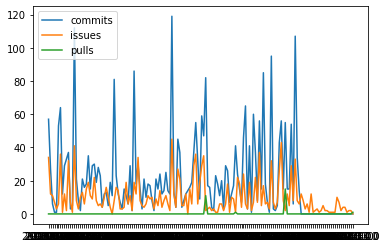

In [49]:
import matplotlib.pyplot as plt
df=Project_handel("ant-ivy").getDf()

plt.plot(df['date'],df['commits'])
plt.plot(df['date'],df['issues'])
plt.plot(df['date'],df['pulls'])
plt.legend(['commits', 'issues', 'pulls'], loc='upper left')
plt.show()


[0 0 4 ... 0 0 0]


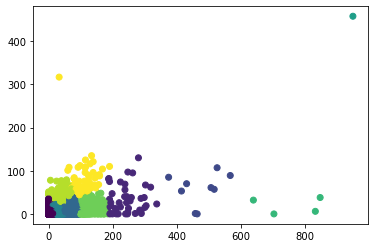

In [25]:
from sklearn.cluster import KMeans
km_test = all_df[['commits', 'issues']].to_numpy()
y_pred = KMeans(n_clusters=10).fit_predict(km_test)
print(y_pred)
plt.scatter(km_test[:,0], km_test[:,1], c=y_pred)